In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import  classification_report, log_loss, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree


#Note: Please add games.csv and ranking.csv file in the Files section

In [ ]:
#returning the decade from the season
def season(data):
 
  return (data%10000)

In [ ]:

#function to add + 1 seasonID to merge current games records with previous seasons standings
def fun_inc(data):
  
   return(data+1)

In [ ]:
#function to dec 1 from SeasonID to get back the original season IDS
def fun_dec(data):
  
  return(data-1)


In [ ]:
#Preprocessing the dataset
def preprocessing():
  games_cols = ['GAME_DATE_EST','GAME_ID','HOME_TEAM_ID','VISITOR_TEAM_ID','SEASON','HOME_TEAM_WINS']
  df = pd.read_csv('games.csv', usecols = games_cols,parse_dates=["GAME_DATE_EST"],infer_datetime_format=True)
  df = df.drop_duplicates().sort_values("GAME_DATE_EST").set_index(["GAME_DATE_EST"])
  team_rank = pd.read_csv('ranking.csv', parse_dates=['STANDINGSDATE'])
  team_rank.sort_values("STANDINGSDATE",inplace = True)

  team_rank['SEASON_ID'] = team_rank['SEASON_ID'].apply(season)


  team_rank['SEASON_ID'] = team_rank['SEASON_ID'].apply(fun_inc)
  team_rank.drop(["HOME_RECORD","CONFERENCE","LEAGUE_ID","ROAD_RECORD"],axis=1,inplace=True) 
  team_rank.set_index("STANDINGSDATE",inplace=True)

  team_rank.astype({'SEASON_ID': 'int32'})
  df_final_rank = team_rank[team_rank["G"]==82]
  df_final_rank = df_final_rank.drop_duplicates()

  #inner Join for the home team
  new_df = pd.merge(df,df_final_rank.add_suffix("_homeTeam"),how = "inner", left_on=["HOME_TEAM_ID", "SEASON"], right_on=['TEAM_ID_homeTeam', "SEASON_ID_homeTeam"])

  #inner Join for the away team
  new_df = pd.merge(new_df,df_final_rank.add_suffix("_visitorTeam"),how = "inner", left_on=["VISITOR_TEAM_ID", "SEASON"], right_on=['TEAM_ID_visitorTeam', "SEASON_ID_visitorTeam"])
  
  new_df.drop(["TEAM_ID_homeTeam","SEASON_ID_visitorTeam","TEAM_ID_visitorTeam"],axis=1,inplace=True)
  new_df['SEASON_ID_homeTeam'] = new_df['SEASON_ID_homeTeam'].apply(fun_dec)
  return new_df

In [ ]:
def fp_fn(confu_matrix):
    fp,fn = {},{}
    fn['Win'] = confu_matrix[1][0]
    fn['Lose'] = confu_matrix[0][1]
    fp['Win'] = confu_matrix[0][1]
    fp['Lose'] = confu_matrix[1][0]
    return fp,fn

In [ ]:
def per_pos(confu_matrix):
    ppos = {}
    ppos['Lose'] = confu_matrix[0][0]/(confu_matrix[0][0]+confu_matrix[0][1])
    ppos['Win'] = confu_matrix[1][1]/(confu_matrix[1][0]+confu_matrix[1][1])
    return ppos

total folds =  5
              precision    recall  f1-score   support

           0       0.40      0.48      0.44      1725
           1       0.60      0.52      0.55      2574

    accuracy                           0.50      4299
   macro avg       0.50      0.50      0.50      4299
weighted avg       0.52      0.50      0.51      4299

              precision    recall  f1-score   support

           0       0.43      0.42      0.42      1735
           1       0.61      0.62      0.61      2564

    accuracy                           0.54      4299
   macro avg       0.52      0.52      0.52      4299
weighted avg       0.54      0.54      0.54      4299

              precision    recall  f1-score   support

           0       0.44      0.45      0.45      1724
           1       0.63      0.62      0.62      2575

    accuracy                           0.55      4299
   macro avg       0.53      0.53      0.53      4299
weighted avg       0.55      0.55      0.55      4299

  

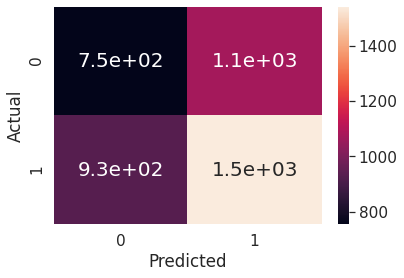

In [ ]:
if __name__ == '__main__':

  #score list keeps record of all 5 fold accuracies
  score = []
  new_df = preprocessing()
  X = new_df.drop(['SEASON'], axis=1)._get_numeric_data().copy()
  y = X["HOME_TEAM_WINS"]
  X = X.drop(["HOME_TEAM_WINS"],axis=1)
  folds = KFold(n_splits = 5)
  print("total folds = ",folds.get_n_splits(X))
    
    
  for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model=tree.DecisionTreeClassifier(criterion="entropy")

    clf = make_pipeline(StandardScaler(),model)
    clf.fit(X_train,y_train)
    test_preds = clf.predict(X_test)
    print(classification_report(y_true=y_test,y_pred=test_preds))
    score.append(accuracy_score(y_true=y_test,y_pred=test_preds))
    
    
  print(f' 5 Fold Cross Validation Accuracy Score is  :  {sum(score)/len(score)} \n\n') 
  conf = confusion_matrix(y_true=y_test,y_pred=test_preds)
  confu_matrix = pd.DataFrame(conf, columns=['Predicted loose', 'Predicted Win'],
    index=['Actual loose', 'Actual Win'])

  print(confu_matrix)
  
  print('\n \n Per Tag Accuracies ')

  ppos = per_pos(conf)
  print(ppos)

  fp,fn = fp_fn(conf)

  print('\n\n False positives ')
  print(fp)

  print('\n \n False Negatives ')
  print(fn)

  sns.set(font_scale=1.4)
  sns.heatmap(conf,annot=True, annot_kws={"size": 20})
  plt.xlabel("Predicted")
  plt.ylabel("Actual") 
  plt.show()